# PoseNet 2D to Kinect 2D

In [71]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [72]:
import warnings
warnings.simplefilter('ignore')

In [86]:
posenetDataPath = '../../datasets/posenet-uncut/'
kinectDataPath = '../../datasets/kinect_good_preprocessed_not_cut/'

X = None
y = None

train_test_ratio = 0.8
random_state = 47

# Model parameters
units = 64
output_layer = ''
learning_rate = 0.001
optimizer = 'Adam'
loss = 'mse'
metrics = ['mae']
epochs = 500
batch_size = 16
layers = [ 
    { 'type': 'Dense', 'nodes':64, 'activation': 'relu' },
    { 'type': 'Dense', 'nodes':64, 'activation': 'relu' },
    { 'type': 'Dense', 'nodes':26, 'activation': 'relu' }
]

# Early stopping parameters
monitor = 'val_loss'
verbose = 1
patience = 20
mode = 'min'
restore_best_weights = True

In [87]:
np.random.seed(random_state)

## 1. Data Preparation

### Load matching files from PoseNet and Kinect

In [88]:
import re

for file in os.listdir(posenetDataPath):
    if file.endswith('.csv'):
        try:
            posenetData = pd.read_csv(posenetDataPath + file)
            kinectData = pd.read_csv(kinectDataPath + '{}_kinect.csv'.format(file.replace('.csv', '')))
            # Check amount of frames
            if (len(posenetData) == len(kinectData)):
                posenetData.drop(columns=['FrameNo'], inplace=True)
                if X is None:
                    X = posenetData
                else:
                    X = pd.concat((X, posenetData), ignore_index=True)

                # Drop Z-columns from Kinect
                z = []
                for c in kinectData.columns:
                    if re.search("^.*_z$", c):
                        z.append(c)
                kinectData.drop(columns=z, inplace=True)
                kinectData.drop(columns=['FrameNo'], inplace=True)
                if y is None:
                    y = kinectData
                else:
                    y = pd.concat((y, kinectData), ignore_index=True)
        except IOError as e:
            print('Error in reading file: ', e)

print(X.shape)
print(y.shape)

(30502, 26)
(30502, 26)


### Training and test split

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=train_test_ratio, random_state=random_state)

input_dim = X_train.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24401, 26)
(24401, 26)
(6101, 26)
(6101, 26)


### Scaling

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ -1.17386797,   0.72013281,  -1.1023334 , ...,   0.4404361 ,
         -1.49153516,   0.83281636],
       [ -0.22128634,  -0.05630455,  -0.2467548 , ...,  -0.31148637,
         -0.64702484,   0.20606775],
       [ -0.47873858,   0.0748577 ,  -0.15326916, ...,  -0.05447137,
          1.01594385,  -0.22030745],
       ...,
       [  2.7756878 ,   0.10767545,   3.15859161, ...,  -0.47772728,
          1.84904656,  -0.30172786],
       [  1.08851202,  -7.49030714,   1.4794711 , ..., -10.04347431,
          1.5473259 ,  -8.96460798],
       [ -1.79499048,   0.75103295,  -1.6323526 , ...,   0.01854431,
         -0.88179427,   0.41256754]])

## 2. DL Model

In [91]:
# Model layer factory
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        return Dropout(units=nodes, activation=activation)
    if type == 'Flatten':
        return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

In [92]:
### Model Architecture

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, InputLayer

model = Sequential([
    InputLayer(input_shape=(input_dim))
])

for layer in layers:
    model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

optimizer = tf.keras.optimizers.get(optimizer)
optimizer.learning_rate.assign(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1728      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 26)                1690      
Total params: 7,578
Trainable params: 7,578
Non-trainable params: 0
_________________________________________________________________


### Early stopping

In [94]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor=monitor, 
    verbose=verbose,
    patience=patience,
    mode=mode,
    restore_best_weights=restore_best_weights)

### Model Training

In [95]:
history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['mae']))

Epoch 1/500
1220/1220 [==============================] - 1s 865us/step - loss: 2596.9744 - mae: 6.7850 - val_loss: 0.1948 - val_mae: 0.3355
Epoch 2/500
1220/1220 [==============================] - 1s 829us/step - loss: 0.1921 - mae: 0.3371 - val_loss: 0.1894 - val_mae: 0.3354
Epoch 3/500
1220/1220 [==============================] - 1s 853us/step - loss: 0.1901 - mae: 0.3361 - val_loss: 0.1893 - val_mae: 0.3354
Epoch 4/500
1220/1220 [==============================] - 1s 822us/step - loss: 0.1905 - mae: 0.3366 - val_loss: 0.1895 - val_mae: 0.3354
Epoch 5/500
1220/1220 [==============================] - 1s 787us/step - loss: 0.1904 - mae: 0.3364 - val_loss: 0.1889 - val_mae: 0.3353
Epoch 6/500
1220/1220 [==============================] - 1s 802us/step - loss: 0.1907 - mae: 0.3367 - val_loss: 0.1889 - val_mae: 0.3353
Epoch 7/500
1220/1220 [==============================] - 1s 742us/step - loss: 0.1893 - mae: 0.3355 - val_loss: 0.1889 - val_mae: 0.3353
Epoch 8/500
1220/1220 [===============

### Plot training and validation MAE & loss per epoch

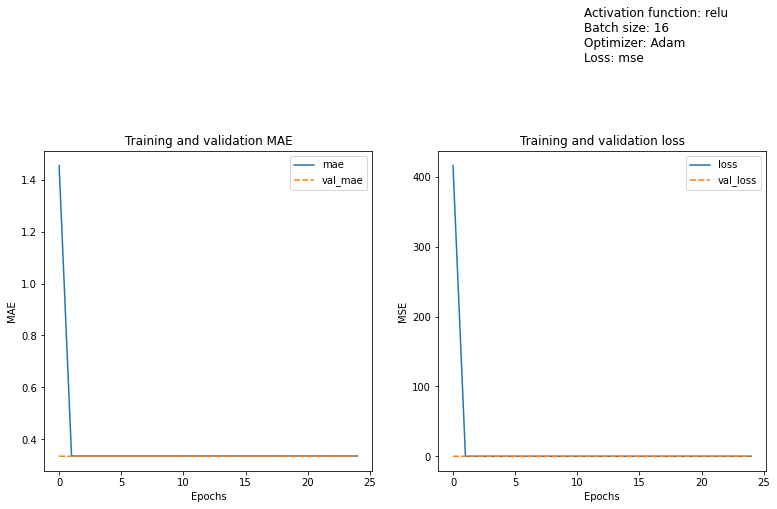

In [96]:
plots = [
           {'cols':['mae', 'val_mae'], 'title':'Training and validation MAE', 'yLabel':'MAE'},
           {'cols':['loss', 'val_loss'], 'title':'Training and validation loss', 'yLabel':'MSE'},
]

fig = plt.figure(figsize=(20,20))
fig_no = 331
title = 'Activation function: {}\nBatch size: {}\nOptimizer: {}\nLoss: {}'.format(activation, batch_size,optimizer._name, loss)
fig.suptitle(title, fontsize="large", horizontalalignment='left', verticalalignment='top')

for i in range(len(plots)):
    ax = fig.add_subplot(str(fig_no))
    sns.lineplot(data=training_history[plots[i]['cols']], ax=ax)
    plt.title(plots[i]['title'])
    plt.xlabel('Epochs')
    plt.ylabel(plots[i]['yLabel'])
    fig_no += 1

plt.show()

### Predictions

In [97]:
predictions = model.predict(x=X_test, verbose=1)

191/191 [==============================] - 0s 402us/step


In [98]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

print('MSE: ', mean_squared_error( y_test, predictions ))
print('MSA: ', mean_absolute_error( y_test, predictions ))
print('R-Squared: ', r2_score( y_test, predictions ))
print('Explained Variance Score: ', explained_variance_score( y_test, predictions ))

MSE:  0.19007815862663233
MSA:  0.336012061105998
R-Squared:  -10.946194687582697
Explained Variance Score:  -1.0248212535001446e-16
